In [2]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install datasets wordcloud 
!{sys.executable} pip install --user -U nltk
!pip install scipy gensim==3.8.3 plotly==4.14.3

/Users/olohireme/opt/anaconda3/bin/python: can't open file 'pip': [Errno 2] No such file or directory
     |████████████████████████████████| 13.2 MB 120 kB/s eta 0:00:01
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11429 sha256=ac25c224ec5a4f21fdb42445df6a2c61be624e1908421c5a3beff4fc211affbd
  Stored in directory: /Users/olohireme/Library/Caches/pip/wheels/c4/a7/48/0a434133f6d56e878ca511c0e6c38326907c0792f67b476e56
Successfully built retrying


In [91]:
# importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec, KeyedVectors
from datasets import load_dataset
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px

In [92]:
# downloading nltk.punkt
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

#### Defining relevant functions

In [93]:
def word_cloud_plot (data):
    """
    function that creates a word cloud from a specified column of a dataframe 
    """
    # create set of stopwords
    stopwords = set(STOPWORDS)

    # Instantiate the word cloud object
    word_cloud = WordCloud(background_color='white',max_words=200,stopwords=stopwords, width=800, height=400)
    
    # generate the word cloud
    word_cloud.generate(' '.join(data))
    
    # To display the word cloud
    plt.figure( figsize=(20,10) )
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [94]:
def regex_filter(sentence):
    """
    funtion that formats string to remove special characters
    """
    import re
    return re.sub('[^a-zA-Z]', ' ', sentence)

In [95]:
def filter_stop_words(token):
    """
    function that removes stopwords from a word-tokenized sentence
    """
    stop_words = set(stopwords.words('english'))
    filtered_token = [word.lower() for word in token if word.lower() not in stop_words]
    return filtered_token

In [96]:
def stem_words(token):
    """
    function that stems word-tokenized sentences
    """
    ps = PorterStemmer()
    stemmed_token = [ps.stem(word) for word in token]
    return stemmed_token

In [97]:
def lemmatize_words(token):
    """
    function that lemmatizes word-tokenized sentences
    """
    lem = WordNetLemmatizer()
    lemmatized_token = [lem.lemmatize(word, 'v') for word in token]
    return lemmatized_token

In [98]:
def join_token(token):
    """
    function that joins word-tokenized sentences back to single string
    """
    return ' '.join(token)

In [99]:
def get_embeddings(group, model):
    group_embedding = []
    group_labels = []
    
    unique_words = [word for sentence in group for word in sentence]
    unique_words = list(dict.fromkeys(unique_words))
    
    for word in unique_words:
        if model.wv.__contains__(word):
            group_embedding.append(list(model.wv.__getitem__(word)))
            group_labels.append(word)
            
    df_embedding = pd.DataFrame(group_embedding)
    df_word = pd.DataFrame(group_labels, columns = ["Word"])
    df = pd.concat([df_word, df_embedding], axis=1)
    return df

In [100]:
def similarity(words, stem_model=None, lem_model=None, W2V_pretrained=None, GloVe_pretrained=None):
    if stem_model:
        ps = PorterStemmer()
        stemmed = [ps.stem(word) for word in words]
        try:
            print("Stemmed W2V model similarity between", words[0], "and", words[1], "=", stem_model.wv.similarity(stemmed[0], stemmed[1]))
        except:
            print("Error: Word not in stem model vocabulary")
    
    if lem_model:
        lem = WordNetLemmatizer()
        lemma = [lem.lemmatize(word, 'v') for word in words]
        try:
            print("Lemmatized W2V model similarity between", words[0], "and", words[1], "=", lem_model.wv.similarity(lemma[0], lemma[1]))
        except:
            print("Error: Word not in lemmatized model vocabulary")        
    
    if W2V_pretrained:
        try:
            print("Word2vec pretrained model similarity between", words[0], "and", words[1], "=", W2V_pretrained.wv.similarity(words[0], words[1]))
        except:
            print("Error: Word not in Word2vec pretrained model vocabulary")
    
    if GloVe_pretrained:
        try:
            print("GloVe pretrained model similarity between", words[0], "and", words[1], "=", GloVe_pretrained.similarity(words[0], words[1]))
        except:
            print("Error: Word not in GloVe pretrained model vocabulary")    

In [101]:
def tsne_plot(df):
    """
    function that plots annotated scatter plot from a dataframe
    """
    plt.figure(figsize=(18, 18)) 
    for i in range(len(df)):
        plt.scatter(df.iloc[i,1],df.iloc[i,2])
        plt.annotate(df.iloc[i,0],
                     xy=(df.iloc[i,1], df.iloc[i,2]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

#### Downloading the dataset

In [102]:
dataset = load_dataset('climate_fever')

df = dataset['test'].to_pandas()
df2 = pd.json_normalize(dataset['test'], 'evidences', ['claim', 'claim_id','claim_label'], errors='ignore',record_prefix='Evidence_')

data1 = df[['claim', 'claim_label']]
data2 = df2[['Evidence_evidence','Evidence_evidence_label']]

Using custom data configuration default
Reusing dataset climate_fever (/Users/olohireme/.cache/huggingface/datasets/climate_fever/default/1.0.1/3b846b20d7a37bc0019b0f0dcbde5bf2d0f94f6874f7e4c398c579f332c4262c)


In [103]:
data1.head()

claim  claim_label
0  Global warming is driving polar bears toward e...            0
1  The sun has gone into ‘lockdown’ which could c...            0
2        The polar bear population has been growing.            1
3  Ironic' study finds more CO2 has slightly cool...            1
4  Human additions of CO2 are in the margin of er...            1

In [104]:
data2.head()

Evidence_evidence  Evidence_evidence_label
0  "Recent Research Shows Human Activity Driving ...                        2
1  Environmental impacts include the extinction o...                        0
2  Rising temperatures push bees to their physiol...                        2
3  Rising global temperatures, caused by the gree...                        0
4    "Bear hunting caught in global warming debate".                        2

#### Histogram plot of claim labels and evidence labels

<AxesSubplot:xlabel='Evidence_evidence_label', ylabel='Count'>

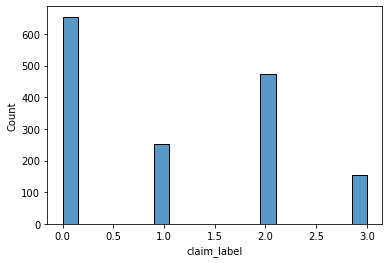

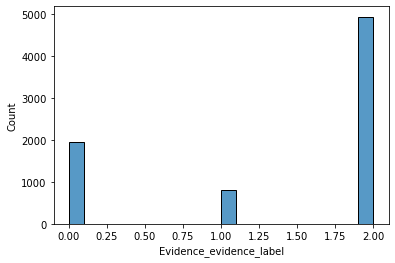

In [105]:
plt.figure()
sns.histplot(data = data1, x ='claim_label', bins = 20)
plt.figure()
sns.histplot(data = data2, x ='Evidence_evidence_label', bins = 20)

#### Word cloud of the claims in the dataset

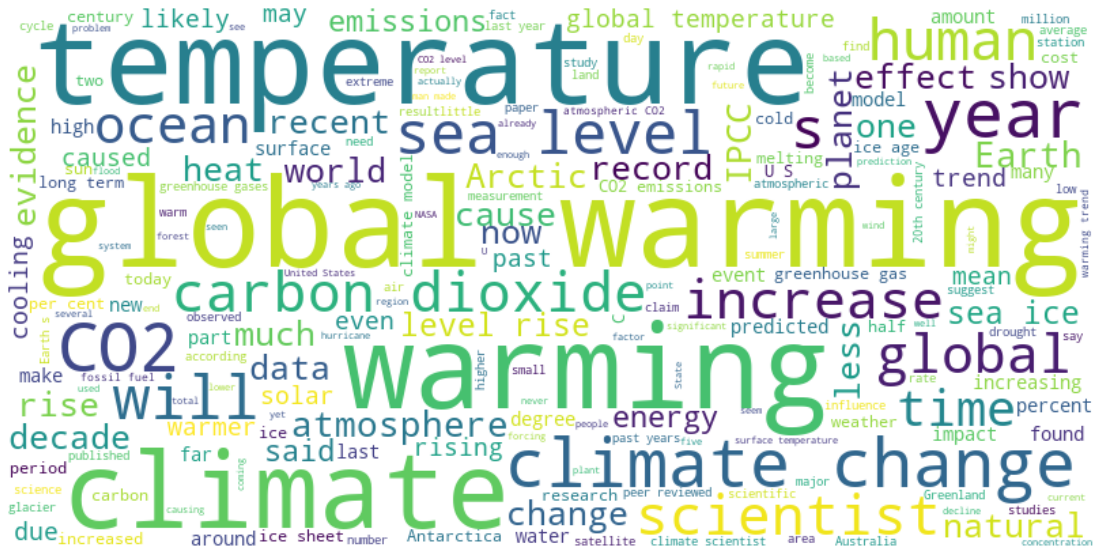

In [106]:
# visualizing word frequency in all claims
word_cloud_plot(data1['claim'])

#### Data preparation

In [107]:
# filter with regex
data1.loc[:, 'claim_token'] = data1.loc[:, 'claim'].apply(regex_filter)

# Tokenizing the claims
data1.loc[:, 'claim_token'] = data1.loc[:, 'claim_token'].apply(nltk.word_tokenize)

# Removing stop words from the claclaim_tokenim tokens
data1.loc[:,'claim_token'] = data1.loc[:,'claim_token'].apply(filter_stop_words)

# Stemming the words
data1.loc[:,'stemmed_words'] = data1.loc[:,'claim_token'].apply(stem_words)

# lemmatizing the words
data1.loc[:,'lemmatized_words'] = data1.loc[:,'claim_token'].apply(lemmatize_words)

/Users/olohireme/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/olohireme/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [108]:
data1.head()

claim  claim_label  \
0  Global warming is driving polar bears toward e...            0   
1  The sun has gone into ‘lockdown’ which could c...            0   
2        The polar bear population has been growing.            1   
3  Ironic' study finds more CO2 has slightly cool...            1   
4  Human additions of CO2 are in the margin of er...            1   

                                         claim_token  \
0  [global, warming, driving, polar, bears, towar...   
1  [sun, gone, lockdown, could, cause, freezing, ...   
2                 [polar, bear, population, growing]   
3  [ironic, study, finds, co, slightly, cooled, p...   
4  [human, additions, co, margin, error, current,...   

                                       stemmed_words  \
0  [global, warm, drive, polar, bear, toward, ext...   
1  [sun, gone, lockdown, could, caus, freez, weat...   
2                         [polar, bear, popul, grow]   
3    [iron, studi, find, co, slightli, cool, planet]   
4  [human, addit, co, margin, error, current, mea...   

                                    lemmatized_words  
0  [global, warm, drive, polar, bear, toward, ext...  
1  [sun, go, lockdown, could, cause, freeze, weat...  
2                    [polar, bear, population, grow]  
3  [ironic, study, find, co, slightly, cool, planet]  
4  [human, additions, co, margin, error, current,...

#### Word cloud of the claims in the dataset (after data preparation)

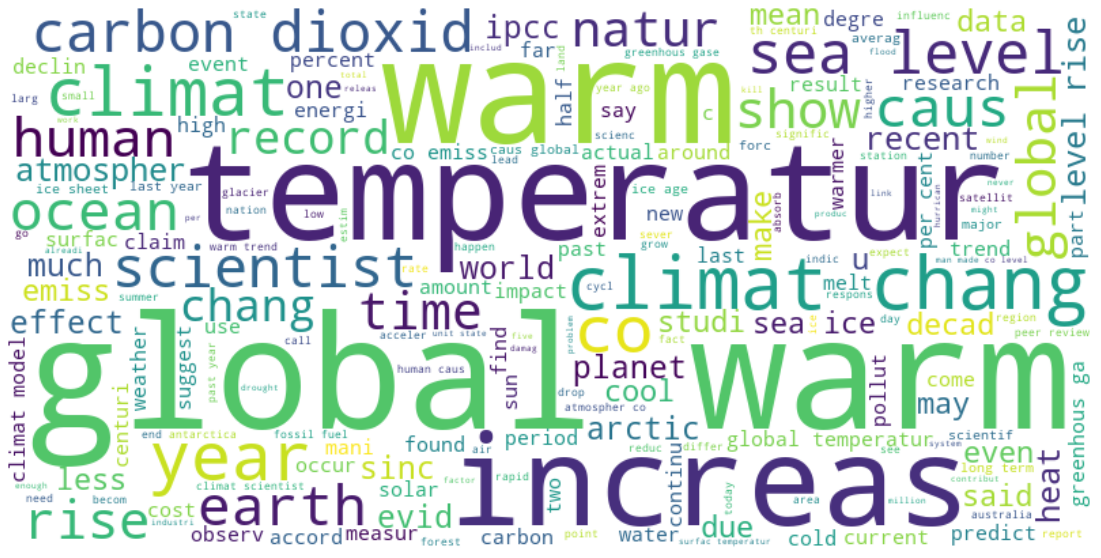

In [109]:
# Visualizing the word cloud again
word_cloud_plot(data1['stemmed_words'].apply(join_token))

#### Creating the corpus

In [110]:
from sklearn.model_selection import train_test_split
train_stem, test_stem = train_test_split(data1['stemmed_words'], test_size=0.2, random_state=0)

train_lem, test_lem = train_test_split(data1['lemmatized_words'], test_size=0.2, random_state=0)

#### Training with the whole dataset

In [111]:
# creating the stemmed corpus and lemmatized corpus
corpus_stem = list(data1['stemmed_words'])
corpus_lem = list(data1['lemmatized_words'])

In [112]:
# getting the length of unique stemmed words
unique_set = [word for token in corpus_stem for word in token]
unique_set = set(unique_set)
len(unique_set)

2962

In [113]:
# getting the length of unique lemmatized words
unique_set2 = [word for token in corpus_lem for word in token]
unique_set2 = set(unique_set2)
len(unique_set2)

3324

#### Building the Word2Vec model

In [114]:
# Embeding with Word2Vec
model_stem_claim = Word2Vec(corpus_stem, min_count=1)
model_lem_claim = Word2Vec(corpus_lem, min_count=1)
print(model_stem_claim)
print(model_lem_claim)

Word2Vec(vocab=2962, size=100, alpha=0.025)
Word2Vec(vocab=3324, size=100, alpha=0.025)


In [115]:
words_list = [['man', 'bear'],['heat', 'warm'],['climate', 'weather'],['earth', 'global']]

In [116]:
for words in words_list:
    similarity(words = words, 
               stem_model = model_stem_claim, 
               lem_model = model_lem_claim
              )
    print()

Stemmed W2V model similarity between man and bear = 0.9782721
Lemmatized W2V model similarity between man and bear = 0.95142007

Stemmed W2V model similarity between heat and warm = 0.998137
Lemmatized W2V model similarity between heat and warm = 0.9966886

Stemmed W2V model similarity between climate and weather = 0.9969926
Lemmatized W2V model similarity between climate and weather = 0.9939381

Stemmed W2V model similarity between earth and global = 0.99723446
Lemmatized W2V model similarity between earth and global = 0.9940059



#### Adding the evidences to the corpus

In [117]:
# Adding the evidences to increase corpus size

# filer with regex
data2.loc[:, ('evidence_token')] = data2.loc[:, ('Evidence_evidence')].apply(regex_filter)

# Tokenizing the claims
data2.loc[:, ('evidence_token')] = data2.loc[:, ('evidence_token')].apply(nltk.word_tokenize)

# Removing stop words from the evidence_token tokens
data2.loc[:,('evidence_token')] = data2.loc[:,('evidence_token')].apply(filter_stop_words)

# Stemming the words
data2.loc[:,('stemmed_words')] = data2.loc[:,('evidence_token')].apply(stem_words)

# lemmatizing the words
data2.loc[:,('lemmatized_words')] = data2.loc[:,('evidence_token')].apply(lemmatize_words)

/Users/olohireme/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/olohireme/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [118]:
data2.head()

Evidence_evidence  Evidence_evidence_label  \
0  "Recent Research Shows Human Activity Driving ...                        2   
1  Environmental impacts include the extinction o...                        0   
2  Rising temperatures push bees to their physiol...                        2   
3  Rising global temperatures, caused by the gree...                        0   
4    "Bear hunting caught in global warming debate".                        2   

                                      evidence_token  \
0  [recent, research, shows, human, activity, dri...   
1  [environmental, impacts, include, extinction, ...   
2  [rising, temperatures, push, bees, physiologic...   
3  [rising, global, temperatures, caused, greenho...   
4   [bear, hunting, caught, global, warming, debate]   

                                       stemmed_words  \
0  [recent, research, show, human, activ, drive, ...   
1  [environment, impact, includ, extinct, reloc, ...   
2  [rise, temperatur, push, bee, physiolog, limit...   
3  [rise, global, temperatur, caus, greenhous, ef...   
4          [bear, hunt, caught, global, warm, debat]   

                                    lemmatized_words  
0  [recent, research, show, human, activity, driv...  
1  [environmental, impact, include, extinction, r...  
2  [rise, temperatures, push, be, physiological, ...  
3  [rise, global, temperatures, cause, greenhouse...  
4          [bear, hunt, catch, global, warm, debate]

#### Word cloud of the evidences in the dataset (after data preparation)

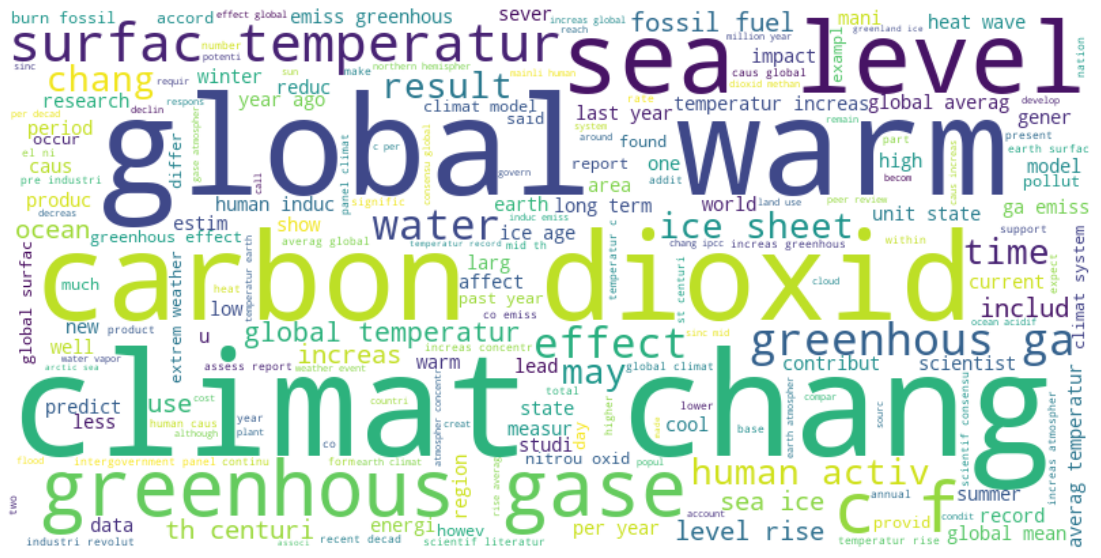

In [119]:
# Visualizing the word cloud of the evidences
word_cloud_plot(data2['stemmed_words'].apply(join_token))

#### Adding the evidences to the corpus

In [120]:
df_stem = pd.concat([data1['stemmed_words'], data2['stemmed_words']])
df_lem = pd.concat([data1['lemmatized_words'], data2['lemmatized_words']])

In [121]:
df_stem.head()

0    [global, warm, drive, polar, bear, toward, ext...
1    [sun, gone, lockdown, could, caus, freez, weat...
2                           [polar, bear, popul, grow]
3      [iron, studi, find, co, slightli, cool, planet]
4    [human, addit, co, margin, error, current, mea...
Name: stemmed_words, dtype: object

In [122]:
df_lem.head()

0    [global, warm, drive, polar, bear, toward, ext...
1    [sun, go, lockdown, could, cause, freeze, weat...
2                      [polar, bear, population, grow]
3    [ironic, study, find, co, slightly, cool, planet]
4    [human, additions, co, margin, error, current,...
Name: lemmatized_words, dtype: object

In [123]:
from sklearn.model_selection import train_test_split
train_stem, test_stem = train_test_split(df_stem, test_size=0.2, random_state=0)

train_lem, test_lem = train_test_split(df_lem, test_size=0.2, random_state=0)

In [124]:
# adding the sentences in the evidence to the corpus
corpus_stem = list(df_stem)
corpus_lem = list(df_lem)

In [125]:
# getting the length of unique stemmed words
unique_set3 = [word for token in corpus_stem for word in token]
unique_set3 = set(unique_set3)
len(unique_set3)

7433

In [126]:
# getting the length of unique lemmatized words
unique_set4 = [word for token in corpus_lem for word in token]
unique_set4 = set(unique_set4)
len(unique_set4)

9055

#### Building the Word2Vec model

In [127]:
# Embeding with Word2Vec
model_stem_total = Word2Vec(corpus_stem, min_count=1)
model_lem_total = Word2Vec(corpus_lem, min_count=1)
print(model_stem_total)
print(model_lem_total)

Word2Vec(vocab=7433, size=100, alpha=0.025)
Word2Vec(vocab=9055, size=100, alpha=0.025)


In [128]:
for words in words_list:
    similarity(words = words, 
               stem_model = model_stem_total, 
               lem_model = model_lem_total
              )
    print()

Stemmed W2V model similarity between man and bear = 0.9204184
Lemmatized W2V model similarity between man and bear = 0.93637

Stemmed W2V model similarity between heat and warm = 0.672225
Lemmatized W2V model similarity between heat and warm = 0.642378

Stemmed W2V model similarity between climate and weather = 0.6773154
Lemmatized W2V model similarity between climate and weather = 0.7278789

Stemmed W2V model similarity between earth and global = 0.93248594
Lemmatized W2V model similarity between earth and global = 0.9237814



#### Comparing with pretrained models

In [129]:
# Loading pretrained Word2Vec model
w2v_data = api.load("text8")
W2V_pretrained = Word2Vec(w2v_data)

In [130]:
# Loading pretrained GloVe model
GloVe_pretrained = api.load("glove-wiki-gigaword-50")

In [131]:
for words in words_list:
    similarity(words = words, 
               stem_model = model_stem_total, 
               lem_model = model_lem_total, 
               W2V_pretrained = W2V_pretrained, 
               GloVe_pretrained = GloVe_pretrained
              )
    print()

Stemmed W2V model similarity between man and bear = 0.9204184
Lemmatized W2V model similarity between man and bear = 0.93637
Word2vec pretrained model similarity between man and bear = 0.269729
GloVe pretrained model similarity between man and bear = 0.5815115

Stemmed W2V model similarity between heat and warm = 0.672225
Lemmatized W2V model similarity between heat and warm = 0.642378
Word2vec pretrained model similarity between heat and warm = 0.53145957
GloVe pretrained model similarity between heat and warm = 0.68190837

Stemmed W2V model similarity between climate and weather = 0.6773154
Lemmatized W2V model similarity between climate and weather = 0.7278789
Word2vec pretrained model similarity between climate and weather = 0.616395
GloVe pretrained model similarity between climate and weather = 0.67468363

Stemmed W2V model similarity between earth and global = 0.93248594
Lemmatized W2V model similarity between earth and global = 0.9237814
Word2vec pretrained model similarity bet

In [132]:
model_stem_total.wv['climat']

array([ 0.6360956 , -0.42495808, -0.63767976,  0.66459227, -0.11117601,
       -0.26221183, -0.38547555, -0.6921642 , -0.08841413,  0.23154837,
        0.2988142 , -0.3638668 ,  0.29529968,  0.06190849, -0.2236488 ,
       -0.5206933 ,  0.70119464,  0.4453088 ,  0.68320924, -0.26955837,
       -0.20473006, -0.45609623, -0.7183208 , -0.83662426,  0.4113865 ,
        0.38858896,  0.25212315, -0.16655825,  1.4788402 ,  0.27991027,
        0.663534  , -0.63685215, -0.6266701 , -0.07104834,  0.03639607,
       -0.8521704 ,  0.4313097 , -0.9220568 , -0.09999236,  0.25640163,
        0.00405554,  0.32856342, -0.55563605,  0.28693458, -0.1608088 ,
        1.1581253 ,  0.227176  , -0.45281273,  0.6478963 , -0.94979507,
       -0.50849086,  0.2992519 ,  1.3994032 , -0.46735385, -0.3648868 ,
        0.22192171,  0.36480632, -0.18968104,  0.16746931, -0.17600955,
       -0.7339229 , -1.4998857 ,  0.06146791, -0.7318247 , -0.1897749 ,
        0.7452823 ,  0.65559566,  0.13478257,  1.162624  ,  0.13

In [133]:
len(model_stem_total.wv.vocab)

7433

In [134]:
train_embedding_stem = get_embeddings(list(train_stem), model_stem_total)
train_embedding_stem.head()

Word         0         1         2         3         4         5  \
0   includ  0.259138 -0.511225 -0.679179  0.459802  0.050719 -0.369158   
1  process  0.317005 -0.650202 -0.495899  0.323689  0.057285 -0.125908   
2   variat  0.265901 -0.504438 -0.614044  0.224198  0.238158 -0.105370   
3    solar  0.600877 -0.813179 -0.507672  0.390254  0.006981 -0.070977   
4   radiat  0.423193 -0.494417 -0.483308  0.205115  0.178347 -0.105285   

          6         7         8  ...        90        91        92        93  \
0 -0.118636 -0.194433 -0.001098  ...  0.428698 -0.699751  0.284220  0.044758   
1 -0.127427 -0.034154  0.232785  ...  0.584704 -0.972929  0.280102  0.152223   
2 -0.178017 -0.206379 -0.022460  ...  0.572625 -0.553524  0.205486  0.071003   
3 -0.103944 -0.000384  0.299228  ...  0.728176 -1.317454  0.344091  0.298216   
4 -0.178466 -0.036578  0.273457  ...  0.479950 -0.917481  0.330470  0.171672   

         94        95        96        97        98        99  
0 -0.353593  0.092409 -0.333733  0.174217 -0.533691 -0.901049  
1 -0.016964 -0.133183 -0.361350  0.171106 -0.387543 -0.677193  
2 -0.110476 -0.333372 -0.491377  0.187487 -0.449005 -0.823221  
3 -0.103984 -0.226260 -0.324299  0.339982 -0.344785 -0.802342  
4  0.129009 -0.300588 -0.198122  0.144418 -0.637560 -0.459939  

[5 rows x 101 columns]

In [135]:
train_embedding_lem = get_embeddings(list(train_lem), model_lem_total)
train_embedding_lem.head()

Word         0         1         2         3         4         5  \
0     include -0.283338  0.098402 -0.022584  0.243497 -0.727842 -0.381786   
1     process -0.292324  0.094964  0.101400  0.203459 -0.835231 -0.306347   
2  variations -0.219842  0.086431  0.063488  0.110652 -0.352366 -0.124773   
3       solar -0.256296  0.007670  0.256133  0.179150 -1.063383 -0.246297   
4   radiation -0.288223  0.218260  0.019727  0.120796 -0.638355 -0.349904   

          6         7         8  ...        90        91        92        93  \
0 -0.392673  0.209179  0.674047  ... -0.218412  0.104425  0.103363 -0.153055   
1 -0.401264  0.112196  0.676808  ... -0.036638 -0.185290 -0.050465 -0.042775   
2 -0.185033  0.044054  0.447754  ...  0.072941  0.042828 -0.098493 -0.007221   
3 -0.476406  0.128763  0.997500  ... -0.148198 -0.456089 -0.093286  0.136191   
4 -0.294291  0.011805  0.493704  ...  0.111454 -0.081832 -0.030974 -0.162175   

         94        95        96        97        98        99  
0 -0.088862 -0.090659 -0.168681  0.000836 -0.364420 -0.280759  
1 -0.052641 -0.180133 -0.166622  0.048450 -0.364154 -0.240293  
2  0.063669 -0.131929 -0.109687  0.051770 -0.233987 -0.322259  
3 -0.014037 -0.262570  0.067394  0.150354 -0.317183 -0.471769  
4 -0.104363 -0.257512 -0.264365 -0.022772 -0.468005 -0.083273  

[5 rows x 101 columns]

#### Getting the test set embeddings

In [136]:
test_embedding_stem = get_embeddings(list(test_stem), model_stem_total)
test_embedding_stem.head()

Word         0         1         2         3         4         5  \
0   choic  0.024664 -0.115643 -0.113673  0.055233  0.020447 -0.028710   
1  author  0.140143 -0.558620 -0.572258  0.269918  0.085784 -0.142009   
2     aim  0.087720 -0.297652 -0.311270  0.128571  0.052349 -0.067330   
3    rang  0.049509 -0.438834 -0.945549  0.067115  0.332042 -0.256008   
4    view  0.099111 -0.371529 -0.447354  0.199996  0.100647 -0.098227   

          6         7         8  ...        90        91        92        93  \
0 -0.030464 -0.017206 -0.002755  ...  0.112174 -0.114630  0.040795  0.009041   
1 -0.161513 -0.150487 -0.019441  ...  0.548325 -0.562836  0.195079  0.022268   
2 -0.085190 -0.081492 -0.014917  ...  0.294474 -0.306281  0.110297  0.023481   
3 -0.275870 -0.473454 -0.426398  ...  0.542205 -0.186257  0.293214 -0.121269   
4 -0.118661 -0.181806 -0.063631  ...  0.409329 -0.311083  0.107636 -0.006604   

         94        95        96        97        98        99  
0 -0.028094 -0.037633 -0.111934  0.025419 -0.034222 -0.150671  
1 -0.141981 -0.163196 -0.546032  0.126102 -0.219109 -0.819415  
2 -0.075197 -0.098967 -0.299805  0.070364 -0.130785 -0.436848  
3 -0.322668 -0.350785 -0.932888  0.049173 -0.529586 -1.152799  
4 -0.128077 -0.147535 -0.414367  0.110708 -0.233254 -0.679928  

[5 rows x 101 columns]

In [137]:
test_embedding_lem = get_embeddings(list(test_lem), model_lem_total)
test_embedding_lem.head()

Word         0         1         2         3         4         5  \
0  choice -0.028869  0.003388  0.006559  0.015538 -0.050631 -0.013074   
1  author -0.180136 -0.006250  0.056813  0.106532 -0.324935 -0.084989   
2     aim -0.104023  0.024382  0.047804  0.063972 -0.222516 -0.060467   
3   range -0.311923  0.233732 -0.066018  0.079119 -0.006024 -0.114589   
4    view -0.149673  0.019389  0.091124  0.098865 -0.316760 -0.096764   

          6         7         8  ...        90        91        92        93  \
0 -0.019960  0.015176  0.061222  ...  0.006268  0.007444 -0.013169 -0.000756   
1 -0.174399  0.062897  0.387652  ...  0.048824  0.090988 -0.088460  0.002111   
2 -0.124374  0.030823  0.253144  ...  0.029889  0.040881 -0.054177  0.011963   
3 -0.029164  0.014460  0.287935  ...  0.376601  0.655212 -0.124329 -0.116457   
4 -0.202553  0.038039  0.389348  ...  0.044885  0.107957 -0.091973  0.009048   

         94        95        96        97        98        99  
0  0.007342 -0.008733 -0.013525  0.002472 -0.030745 -0.047667  
1  0.104308 -0.073857 -0.101246  0.082540 -0.150908 -0.341412  
2  0.051322 -0.055000 -0.072774  0.047882 -0.112914 -0.205642  
3  0.240589 -0.148286 -0.513114  0.015151 -0.298196 -0.551895  
4  0.088526 -0.083406 -0.108372  0.090817 -0.160073 -0.343659  

[5 rows x 101 columns]

#### Getting Cosine similarity between all  words

In [138]:
cos_sim_w2v = cosine_similarity(test_embedding_stem.iloc[:,1:].values, Y=None, dense_output=True)

In [139]:
cos_sim_w2v.shape

(3783, 3783)

In [140]:
cos_sim_w2v = pd.DataFrame(cos_sim_w2v, columns = list(test_embedding_stem["Word"]), index = list(test_embedding_stem["Word"]))

In [141]:
cos_sim_w2v.head()

choic    author       aim      rang      view  expertis  geograph  \
choic   1.000000  0.993738  0.993527  0.853889  0.969169  0.976258  0.995299   
author  0.993738  1.000000  0.998112  0.864242  0.986941  0.989653  0.994261   
aim     0.993527  0.998112  1.000000  0.877361  0.984826  0.985369  0.996204   
rang    0.853889  0.864242  0.877361  1.000000  0.895645  0.870802  0.893022   
view    0.969169  0.986941  0.984826  0.895645  1.000000  0.994205  0.980092   

        represent     ensur    expert  ...   recharg   lithium  activist  \
choic    0.994031  0.997473  0.989146  ...  0.962324  0.981705  0.988314   
author   0.996316  0.996321  0.997940  ...  0.959951  0.980598  0.993922   
aim      0.997049  0.997909  0.995544  ...  0.969507  0.986113  0.994036   
rang     0.873973  0.874396  0.868687  ...  0.933948  0.924666  0.857843   
view     0.980520  0.978628  0.991193  ...  0.955249  0.975228  0.978543   

            talk   pathway   utterli    barren       fog    sweden    vanish  
choic   0.996303  0.925530  0.988469  0.992836  0.990372  0.981542  0.955634  
author  0.995172  0.923747  0.991698  0.989142  0.984577  0.975042  0.961769  
aim     0.995646  0.935049  0.994100  0.990379  0.988882  0.980890  0.963808  
rang    0.859185  0.825650  0.906009  0.839990  0.897879  0.914958  0.945817  
view    0.974733  0.895255  0.987232  0.961846  0.966954  0.961709  0.972047  

[5 rows x 3783 columns]

### Arithmetic Relationships
Scientist, peer, review, publish
greenhouse, carbon, dioxide
decade, year, today

In [142]:
#Relationship 1
#ICE + WARM - COLD = WATER/SEA/OCEAN
model_stem_total.wv.most_similar(positive=['ice', 'warm'], negative=['cold'], topn=5)

[('rise', 0.87005615234375),
 ('level', 0.8457924127578735),
 ('arctic', 0.7913667559623718),
 ('acceler', 0.7904752492904663),
 ('contribut', 0.7858021259307861)]

In [143]:
model_lem_total.wv.most_similar(positive=['ice', 'warm'], negative=['cold'], topn=5)

[('rise', 0.9007216691970825),
 ('level', 0.8855571150779724),
 ('sight', 0.8739469647407532),
 ('sea', 0.8511159420013428),
 ('initiate', 0.8474575877189636)]

In [144]:
#Relationship 2
#dark + sun - night = day/light
model_stem_total.wv.most_similar(positive=['hydro', 'gase'], negative=['carbon'],  topn=5)

[('impact', 0.9684469699859619),
 ('magnitud', 0.9665506482124329),
 ('variabl', 0.965319812297821),
 ('endors', 0.9648280143737793),
 ('conjunct', 0.9645508527755737)]

In [145]:
model_lem_total.wv.most_similar(positive=['hydro', 'gas'], negative=['carbon'],  topn=5)

[('hothouse', 0.9711857438087463),
 ('trajectory', 0.9671000838279724),
 ('magnitude', 0.9642156362533569),
 ('impact', 0.964063286781311),
 ('environment', 0.9640166759490967)]

In [146]:
#Relationship 3
#rising + gradual - increasing = slow
model_stem_total.wv.most_similar(positive=['rise', 'gradual'], negative=['increas'],  topn=5)

[('ft', 0.9629474878311157),
 ('shrunk', 0.9599590301513672),
 ('centimet', 0.9540309906005859),
 ('metr', 0.9529752731323242),
 ('outflow', 0.9522228240966797)]

In [147]:
#rising + gradual - increasing
model_lem_total.wv.most_similar(positive=['rise', 'gradual'], negative=['increase'],  topn=5)

[('shrinkage', 0.9405319690704346),
 ('sea', 0.9385865926742554),
 ('ft', 0.9362698197364807),
 ('arctic', 0.9301565885543823),
 ('antarctic', 0.9293390512466431)]

In [148]:
#Relationship 4
#summer + cold - solar = winter
model_stem_total.wv.most_similar(positive=['north', 'pole'], negative=['arctic'],  topn=5)

[('northernmost', 0.9808530211448669),
 ('pari', 0.9673133492469788),
 ('everi', 0.9665008187294006),
 ('decemb', 0.9659568071365356),
 ('juli', 0.9657777547836304)]

In [149]:
model_lem_total.wv.most_similar(positive=['north', 'pole'], negative=['arctic'], topn=5)

[('compute', 0.9738805890083313),
 ('negotiate', 0.9676755666732788),
 ('every', 0.9674712419509888),
 ('longest', 0.9671669006347656),
 ('medium', 0.9665514826774597)]

In [150]:
#Relationship 5
#climate + temperature - weather
model_stem_total.wv.most_similar(positive=['climat', 'temperatur'], negative=['weather'],  topn=5)

[('consensu', 0.8594763875007629),
 ('global', 0.8551439046859741),
 ('overwhelm', 0.8467347621917725),
 ('recent', 0.8324794769287109),
 ('warm', 0.8275279402732849)]

In [151]:
model_lem_total.wv.most_similar(positive=['climate', 'temperature'], negative=['weather'],  topn=5)

[('potentials', 0.9370420575141907),
 ('observe', 0.883090615272522),
 ('consensus', 0.8811293840408325),
 ('warm', 0.876931369304657),
 ('unequivocal', 0.8768463134765625)]

In [152]:
W2V_pretrained.wv.most_similar(positive=['ice', 'warm'], negative=['cold'],  topn=5)

[('rocks', 0.6588494777679443),
 ('snow', 0.6450827717781067),
 ('glacier', 0.6436892151832581),
 ('beds', 0.637380838394165),
 ('rain', 0.6204835772514343)]

In [153]:
GloVe_pretrained.wv.most_similar(positive=['ice', 'warm'], negative=['cold'],  topn=5)

<ipython-input-153-1ec3bbdb9b68>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  GloVe_pretrained.wv.most_similar(positive=['ice', 'warm'], negative=['cold'],  topn=5)


[('plate', 0.7150593996047974),
 ('silver', 0.6485081911087036),
 ('sparkling', 0.636193573474884),
 ('skate', 0.6235347986221313),
 ('cream', 0.6151865720748901)]

In [154]:
W2V_pretrained.wv.most_similar(positive=['hydro', 'gas'], negative=['carbon'],  topn=5)

[('tanker', 0.6214826107025146),
 ('liquefied', 0.6080482006072998),
 ('liquified', 0.601992130279541),
 ('electricity', 0.5868544578552246),
 ('petrol', 0.571129322052002)]

In [155]:
GloVe_pretrained.wv.most_similar(positive=['hydro', 'gas'], negative=['carbon'],  topn=5)

<ipython-input-155-2ba09357030c>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  GloVe_pretrained.wv.most_similar(positive=['hydro', 'gas'], negative=['carbon'],  topn=5)


[('statoil', 0.7187291383743286),
 ('pipeline', 0.6830664873123169),
 ('refinery', 0.6819669008255005),
 ('hydroelectric', 0.6683335304260254),
 ('electricity', 0.6475889682769775)]

In [156]:
W2V_pretrained.wv.most_similar(positive=['rise', 'gradual'], negative=['increase'],  topn=5)

[('emergence', 0.5919860601425171),
 ('modernism', 0.590330958366394),
 ('neo', 0.534286379814148),
 ('renaissance', 0.5228511691093445),
 ('chaos', 0.5166429281234741)]

In [157]:
GloVe_pretrained.wv.most_similar(positive=['rise', 'gradual'], negative=['increase'],  topn=5)

<ipython-input-157-026c8898a0fe>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  GloVe_pretrained.wv.most_similar(positive=['rise', 'gradual'], negative=['increase'],  topn=5)


[('inexorable', 0.7363816499710083),
 ('upturn', 0.7345753908157349),
 ('precipitous', 0.725489616394043),
 ('stagnation', 0.7136895060539246),
 ('downward', 0.6995311379432678)]

In [158]:
W2V_pretrained.wv.most_similar(positive=['north', 'pole'], negative=['arctic'], topn=3)

[('south', 0.6266376972198486),
 ('west', 0.4995671808719635),
 ('nisjoki', 0.46428871154785156)]

In [159]:
GloVe_pretrained.wv.most_similar(positive=['north', 'pole'], negative=['arctic'], topn=3)

<ipython-input-159-7d315d12d06e>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  GloVe_pretrained.wv.most_similar(positive=['north', 'pole'], negative=['arctic'], topn=3)


[('fifth', 0.7316383719444275),
 ('third', 0.7275133728981018),
 ('sixth', 0.7260597348213196)]

In [160]:
W2V_pretrained.wv.most_similar(positive=['climate', 'temperature'], negative=['weather'],  topn=5)

[('temperatures', 0.6001119017601013),
 ('enthalpy', 0.5888274312019348),
 ('density', 0.5870642066001892),
 ('coefficient', 0.5866705775260925),
 ('entropy', 0.578767716884613)]

In [161]:
GloVe_pretrained.wv.most_similar(positive=['climate', 'temperature'], negative=['weather'],  topn=5)

<ipython-input-161-92ac769b420e>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  GloVe_pretrained.wv.most_similar(positive=['climate', 'temperature'], negative=['weather'],  topn=5)


[('carbon', 0.7083598375320435),
 ('warming', 0.6987556219100952),
 ('greenhouse', 0.680810809135437),
 ('co2', 0.6696141958236694),
 ('ph', 0.6661812663078308)]

### Applying KNN on the Embeddings

In [162]:
knn_data_stem = data1[['claim', 'stemmed_words', 'claim_label']]
knn_data_stem.head()

claim  \
0  Global warming is driving polar bears toward e...   
1  The sun has gone into ‘lockdown’ which could c...   
2        The polar bear population has been growing.   
3  Ironic' study finds more CO2 has slightly cool...   
4  Human additions of CO2 are in the margin of er...   

                                       stemmed_words  claim_label  
0  [global, warm, drive, polar, bear, toward, ext...            0  
1  [sun, gone, lockdown, could, caus, freez, weat...            0  
2                         [polar, bear, popul, grow]            1  
3    [iron, studi, find, co, slightli, cool, planet]            1  
4  [human, addit, co, margin, error, current, mea...            1

In [163]:
def get_sentence_embedding(data, column, train_word_embedding, test_word_embedding):
    sentence_embeddings = []
    for token in data[column]:
        embeddings = []
        for word in token:
            if word in train_word_embedding.index:
                embeddings.append(train_word_embedding.loc[word])
            else:
                embeddings.append(test_word_embedding.loc[word])
        
        embedding_array = np.array(embeddings)
        sentence_embedding = np.mean(embedding_array, axis=0)
        sentence_embeddings.append(list(sentence_embedding))
        
    features = len(sentence_embeddings[0])
    df = pd.DataFrame(sentence_embeddings, columns = ["feature_"+ str(i+1) for i in range(features)])
    df = pd.concat([df["claim"], df, df["claim_label"]], axis=1)
    return df   

In [164]:
def get_sentence_embedding(data, column, model):
    sentence_embeddings = []
    for token in data[column]:
        embeddings = []
        for word in token:
            embeddings.append(list(model.wv.__getitem__(word)))
        
        embedding_array = np.array(embeddings)
        sentence_embedding = np.mean(embedding_array, axis=0)
        sentence_embeddings.append(list(sentence_embedding))
        
    features = len(sentence_embeddings[0])
    df = pd.DataFrame(sentence_embeddings, columns = ["feature_"+ str(i+1) for i in range(features)])
    df = pd.concat([data[["claim", column]], df, data["claim_label"]], axis=1)
    return df   

In [165]:
get_sentence_embedding(knn_data_stem, 'stemmed_words', model_stem_total)

claim  \
0     Global warming is driving polar bears toward e...   
1     The sun has gone into ‘lockdown’ which could c...   
2           The polar bear population has been growing.   
3     Ironic' study finds more CO2 has slightly cool...   
4     Human additions of CO2 are in the margin of er...   
...                                                 ...   
1530  About 60% of the warming observed from 1970 to...   
1531  "Skeptics hope that Postma’s alternative therm...   
1532  "There are other possible causes for climate c...   
1533  We don't need a high heat flow - just a high t...   
1534  Over the last decade, heatwaves are five times...   

                                          stemmed_words  feature_1  feature_2  \
0     [global, warm, drive, polar, bear, toward, ext...   0.185557  -0.331911   
1     [sun, gone, lockdown, could, caus, freez, weat...   0.149206  -0.311811   
2                            [polar, bear, popul, grow]   0.018260  -0.587775   
3       [iron, studi, find, co, slightli, cool, planet]   0.185952  -0.408423   
4     [human, addit, co, margin, error, current, mea...   0.156197  -0.386504   
...                                                 ...        ...        ...   
1530  [warm, observ, like, caus, natur, year, climat...   0.427162  -0.344767   
1531  [skeptic, hope, postma, altern, thermal, model...   0.099645  -0.364078   
1532  [possibl, caus, climat, chang, could, associ, ...   0.309628  -0.373365   
1533  [need, high, heat, flow, high, temperatur, cor...   0.215085  -0.408666   
1534  [last, decad, heatwav, five, time, like, globa...   0.252625  -0.236635   

      feature_3  feature_4  feature_5  feature_6  feature_7  feature_8  ...  \
0     -0.566866   0.154528   0.273937  -0.146198  -0.145077  -0.240327  ...   
1     -0.428642   0.133612   0.148456  -0.121563  -0.130079  -0.146635  ...   
2     -0.697708   0.253170   0.159147  -0.189805  -0.119343  -0.095694  ...   
3     -0.483004   0.137095   0.167194  -0.094914  -0.145079  -0.129064  ...   
4     -0.506252   0.053971   0.254107  -0.102468  -0.093311  -0.082768  ...   
...         ...        ...        ...        ...        ...        ...  ...   
1530  -0.604588   0.141968   0.350077  -0.091997  -0.247285  -0.386590  ...   
1531  -0.436196   0.206083   0.093309  -0.114211  -0.125096  -0.153808  ...   
1532  -0.575966   0.167970   0.250249  -0.124262  -0.201240  -0.307431  ...   
1533  -0.678082   0.117690   0.251281  -0.175127  -0.229803  -0.309115  ...   
1534  -0.620313  -0.064049   0.456891  -0.047068  -0.225420  -0.422540  ...   

      feature_92  feature_93  feature_94  feature_95  feature_96  feature_97  \
0      -0.365301    0.160561    0.007685   -0.075788   -0.238839   -0.342926   
1      -0.351370    0.140837    0.014258   -0.118405   -0.168566   -0.295191   
2      -0.429210    0.247136    0.011866   -0.204647   -0.199860   -0.620176   
3      -0.531970    0.187255    0.059217    0.020002   -0.242799   -0.408640   
4      -0.535706    0.192593    0.081263    0.071337   -0.301032   -0.296883   
...          ...         ...         ...         ...         ...         ...   
1530   -0.640434    0.083487    0.046358   -0.003549   -0.395965   -0.292389   
1531   -0.338019    0.139112    0.003929   -0.110859   -0.109306   -0.423349   
1532   -0.558383    0.175442    0.049079   -0.084840   -0.265486   -0.387765   
1533   -0.437878    0.257691   -0.011703   -0.110826   -0.239731   -0.559135   
1534   -0.304749    0.074423   -0.018909    0.041513   -0.542256   -0.386806   

      feature_98  feature_99  feature_100  claim_label  
0       0.121991   -0.581835    -0.667315            0  
1       0.118573   -0.359976    -0.568816            0  
2       0.074426   -0.182914    -0.801439            1  
3       0.074155   -0.378212    -0.568334            1  
4       0.050885   -0.497734    -0.419157            1  
...          ...         ...          ...          ...  
1530    0.262428   -0.928548    -0.853137            2  
15

## PCA

### CM2

### Q.1 Using Stemming

In [166]:
from sklearn.decomposition import PCA
n_components = 30
pca = PCA(n_components=n_components)
pca.fit_transform(train_embedding_stem.iloc[:,1:].values)
explained_variance = pca.explained_variance_ratio_

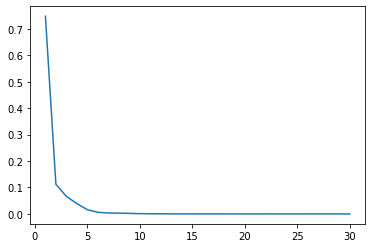

In [167]:
plt.plot(range(1, n_components + 1), explained_variance)

Explained variance tells us how much information can be attributed to each of the principal components. The explained variance reduces as the number of components increases which shows that most of the information is held by the first 5 components. 
The "elbow" of the graph is where the value of explained variance seems to level off and factors or components to the left of this point should be retained as significant.


### Q.2 
**From the scree plot above, the best dimensionality is 5**

In [168]:
# Building optimal PCA model
pca = PCA(n_components=5)
pca_train = pca.fit_transform(train_embedding_stem.iloc[:,1:].values)
pca_test = pca.transform(test_embedding_stem.iloc[:,1:].values)

### Q.3 


In [169]:
columns = ['PC_1','PC_2','PC_3','PC_4','PC_5']
pca_test = pd.DataFrame(pca_test, columns = columns)
pca_test["Word"] = test_embedding_stem["Word"]
pca_test = pca_test[['Word','PC_1','PC_2','PC_3','PC_4','PC_5']]
pca_test.head()

Word      PC_1      PC_2      PC_3      PC_4      PC_5
0   choic -0.043947  0.032360 -0.063584  0.041216  0.014117
1  author  2.575825  0.174749 -0.567225 -0.078683  0.012066
2     aim  1.102322  0.075067 -0.210856 -0.049690  0.057830
3    rang  3.859232 -1.919923  0.324311 -0.511094  0.040058
4    view  1.708751 -0.108893 -0.437633 -0.341233 -0.094829

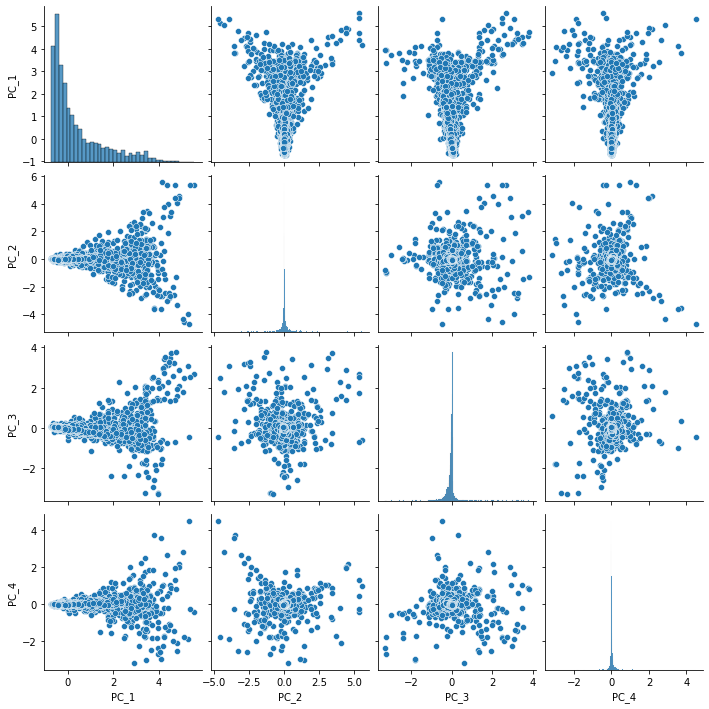

In [170]:
sns.pairplot(pca_test.iloc[:,1:5])

In [171]:
pca_test.shape

(3783, 6)

#### Discussion on PCA embeddings 
- The first principle component is highly skewed to the left. It has a lot of variance, this is likely because about 70% of the variance in the data comes from this feature
- The variance in the second, third and fourth principal components is quite small
- The first four principal components have little or no correlation with each other. 
- PCA speed, compare running times of all 4 methods


### Using Lemmatization

In [172]:
pca = PCA(n_components=n_components)
pca.fit_transform(train_embedding_lem.iloc[:,1:].values)
explained_variance = pca.explained_variance_ratio_

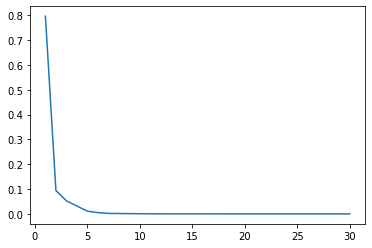

In [173]:
plt.plot(range(1, n_components + 1), explained_variance)

In [174]:
# Building optimal PCA model
pca = PCA(n_components=5)
pca_train = pca.fit_transform(train_embedding_lem.iloc[:,1:].values)
pca_test = pca.transform(test_embedding_lem.iloc[:,1:].values)

In [175]:
pca_test = pd.DataFrame(pca_test, columns = columns)
pca_test["Word"] = test_embedding_lem["Word"]
pca_test = pca_test[['Word','PC_1','PC_2','PC_3','PC_4','PC_5']]
pca_test.head()

Word      PC_1      PC_2      PC_3      PC_4      PC_5
0  choice -0.216373  0.017862 -0.010723 -0.002256  0.006823
1  author  2.059634  0.107087 -0.410502 -0.214948  0.024366
2     aim  1.163197  0.124098 -0.134124 -0.124521  0.041072
3   range  4.501019 -1.803198  0.207348 -0.375401 -0.049618
4    view  2.035798  0.210326 -0.283235 -0.364521 -0.042523

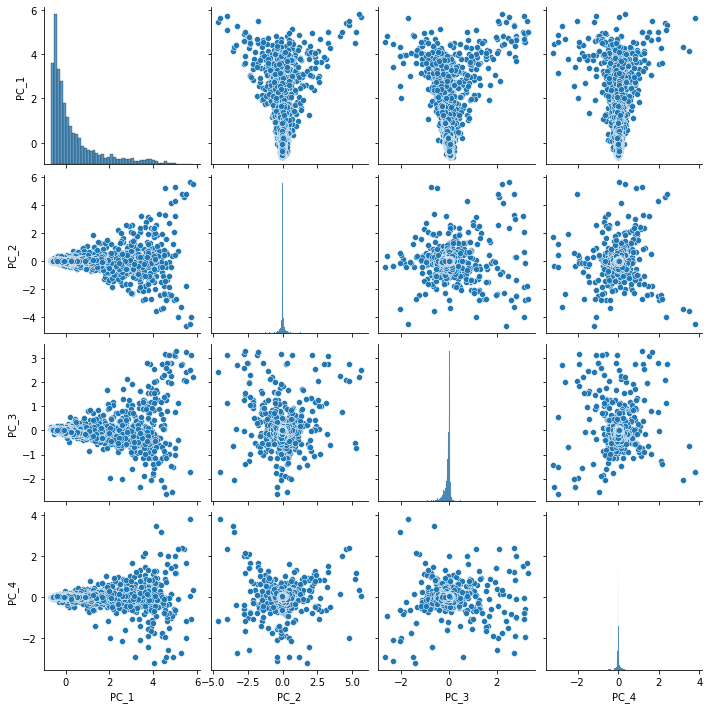

In [176]:
sns.pairplot(pca_test.iloc[:,1:5])

#### Q.4 Getting Cosine similarity between all  words

In [177]:
cos_sim_pca = cosine_similarity(pca_test.iloc[:,1:].values, Y=None, dense_output=False)

In [178]:
cos_sim_pca.shape

(4402, 4402)

In [179]:
cos_sim_pca = pd.DataFrame(cos_sim_pca, columns = list(pca_test["Word"]), index = list(pca_test["Word"]))
cos_sim_pca

choice    author       aim     range      view  expertise  \
choice    1.000000 -0.954132 -0.960401 -0.951903 -0.949085  -0.884451   
author   -0.954132  1.000000  0.994957  0.881543  0.993910   0.979541   
aim      -0.960401  0.994957  1.000000  0.871937  0.995823   0.966412   
range    -0.951903  0.881543  0.871937  1.000000  0.867729   0.803384   
view     -0.949085  0.993910  0.995823  0.867729  1.000000   0.979801   
...            ...       ...       ...       ...       ...        ...   
barren    0.997312 -0.970734 -0.976953 -0.935442 -0.965258  -0.908471   
fog       0.996482 -0.965537 -0.971370 -0.955097 -0.962713  -0.902084   
sweden    0.967311 -0.986337 -0.994435 -0.871263 -0.993424  -0.958465   
rotation  0.732021 -0.869979 -0.860762 -0.568344 -0.845459  -0.885479   
vanish    0.980411 -0.982494 -0.993851 -0.897644 -0.985176  -0.934841   

          geographical  representation    ensure   experts  ...  reactions  \
choice        0.595194        0.929026 -0.964160 -0.937452  ...   0.967139   
author       -0.496221       -0.884152  0.991448  0.997157  ...  -0.969443   
aim          -0.577298       -0.922137  0.991971  0.986922  ...  -0.954439   
range        -0.449791       -0.793292  0.873489  0.862316  ...  -0.951332   
view         -0.566066       -0.909082  0.979920  0.984893  ...  -0.945229   
...                ...             ...       ...       ...  ...        ...   
barren        0.591436        0.934232 -0.980515 -0.957114  ...   0.971739   
fog           0.594614        0.923082 -0.968522 -0.948483  ...   0.972964   
sweden        0.617496        0.945219 -0.983752 -0.974405  ...   0.940649   
rotation      0.295992        0.713523 -0.884328 -0.896255  ...   0.790715   
vanish        0.631474        0.948118 -0.986795 -0.968498  ...   0.954674   

          pathways   methods   sectors   utterly    barren       fog  \
choice    0.986335 -0.970024  0.998587  0.938738  0.997312  0.996482   
author   -0.984523  0.993679 -0.963782 -0.916288 -0.970734 -0.965537   
aim      -0.988468  0.986451 -0.967139 -0.939699 -0.976953 -0.971370   
range    -0.909803  0.910446 -0.957938 -0.791085 -0.935442 -0.955097   
view     -0.975934  0.978474 -0.958570 -0.914743 -0.965258 -0.962713   
...            ...       ...       ...       ...       ...       ...   
barren    0.995597 -0.982245  0.997244  0.951247  1.000000  0.996455   
fog       0.987854 -0.976320  0.998880  0.926013  0.996455  1.000000   
sweden    0.985864 -0.976431  0.970793  0.950193  0.979891  0.972659   
rotation  0.832351 -0.854735  0.739878  0.831825  0.777408  0.740773   
vanish    0.993700 -0.980907  0.983171  0.954490  0.990783  0.987227   

            sweden  rotation    vanish  
choice    0.967311  0.732021  0.980411  
author   -0.986337 -0.869979 -0.982494  
aim      -0.994435 -0.860762 -0.993851  
range    -0.871263 -0.568344 -0.897644  
view     -0.993424 -0.845459 -0.985176  
...            ...       ...       ...  
barren    0.979891  0.777408  0.990783  
fog       0.972659  0.740773  0.987227  
sweden    1.000000  0.833281  0.992980  
rotation  0.833281  1.000000  0.815546  
vanish    0.992980  0.815546  1.000000  

[4402 rows x 4402 columns]

In [189]:
words_list = [['man', 'bear'],['heat', 'warm'],['climate', 'weather'],['earth', 'global'], ['scientist', 'publish']]
for word in words_list:
    print("The Cos similarity of PCA embeddings between", word[0], "and", word[1], "is", cos_sim_pca.at[word[0], word[1]])
    similarity(words = word, 
               stem_model = model_stem_claim, 
               lem_model = model_lem_claim
              )

The Cos similarity of PCA embeddings between man and bear is 0.8763667441380066
Stemmed W2V model similarity between man and bear = 0.9782721
Lemmatized W2V model similarity between man and bear = 0.95142007
The Cos similarity of PCA embeddings between heat and warm is 0.5931195109485464
Stemmed W2V model similarity between heat and warm = 0.998137
Lemmatized W2V model similarity between heat and warm = 0.9966886
The Cos similarity of PCA embeddings between climate and weather is 0.7092806283514207
Stemmed W2V model similarity between climate and weather = 0.9969926
Lemmatized W2V model similarity between climate and weather = 0.9939381
The Cos similarity of PCA embeddings between earth and global is 0.932922447921945
Stemmed W2V model similarity between earth and global = 0.99723446
Lemmatized W2V model similarity between earth and global = 0.9940059
The Cos similarity of PCA embeddings between scientist and publish is 0.9639015662412186
Stemmed W2V model similarity between scientist 

In [ ]:
#cosine similarity by cluster. 
#Since cosine similarity with words by every other word is not possible. 
#Or maybe most common words with their 20 neighbours from KNN
#Definition and formula for Cosine similarity

### Notes About Cosine Similarity
Cosine Similarity computes the L2-normalized dot product of vectors. That is, if $x$  and $y$ are row vectors, their cosine similarity $k$ is defined as:

$k(x,y) = \frac{xy^T}{\|x\|y\|}$


Negative values of cosine similarity denote a strongly opposite correlation between words.

## CM3 - LLE

### Using Stemming

In [191]:
from sklearn.manifold import LocallyLinearEmbedding

In [192]:
n_components = [1, 2, 3, 5, 7, 10, 20, 30]
reconstruction_error = []
for n in n_components:
    lle_model = LocallyLinearEmbedding(n_components=n, random_state=0)
    lle_vectors = lle_model.fit_transform(test_embedding_stem.iloc[:,1:].values)
    reconstruction_error.append(lle_model.reconstruction_error_)

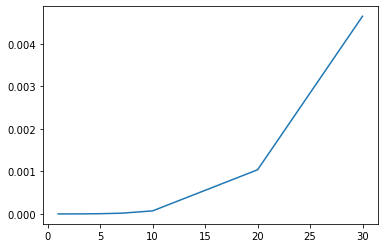

In [193]:
plt.plot(n_components, reconstruction_error)

From the plot above we can see that the reconstruction error increases with the number of components. Why?

In [194]:
lle_model = LocallyLinearEmbedding(n_components=4, random_state=0)
lle_vectors = lle_model.fit_transform(test_embedding_stem.iloc[:,1:].values)

df_lle = pd.DataFrame(lle_vectors, columns = ["feature1", "feature2", "feature3", "feature4"])
df_lle["Word"] = test_embedding_stem["Word"]
df_lle = df_lle[["Word", "feature1", "feature2", "feature3", "feature4"]]

In [195]:
df_lle.head()

Word  feature1  feature2  feature3  feature4
0   choic  0.001551 -0.004948  0.027775 -0.002273
1  author  0.000342 -0.018909 -0.016743 -0.002408
2     aim  0.002711 -0.018597 -0.014262  0.009005
3    rang  0.000644 -0.019066 -0.017761 -0.022827
4    view  0.002344 -0.019082 -0.016635  0.001415

In [196]:
lle_model.reconstruction_error_

2.1258535772636736e-06

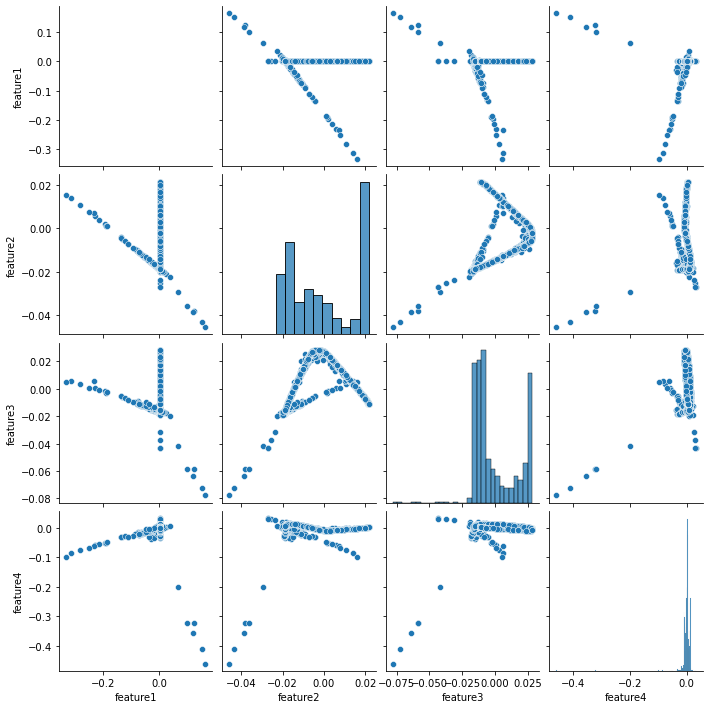

In [197]:
sns.pairplot(df_lle.iloc[:,1:5])

### Using Lemmatization

In [198]:
n_components = [1, 2, 3, 5, 7, 10, 20, 30]
reconstruction_error = []
for n in n_components:
    lle_model = LocallyLinearEmbedding(n_components=n, random_state=0)
    lle_vectors = lle_model.fit_transform(test_embedding_lem.iloc[:,1:].values)
    reconstruction_error.append(lle_model.reconstruction_error_)

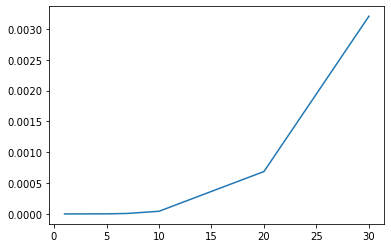

In [199]:
plt.plot(n_components, reconstruction_error)

Applying LLE on the lemmatized corpus has a slightly lower reconstruction error as compared to the stemmed corpus

In [200]:
lle_model = LocallyLinearEmbedding(n_components=4, random_state=0)
lle_vectors = lle_model.fit_transform(test_embedding_lem.iloc[:,1:].values)

df_lle = pd.DataFrame(lle_vectors, columns = ["feature1", "feature2", "feature3", "feature4"])
df_lle["Word"] = test_embedding_lem["Word"]
df_lle = df_lle[["Word", "feature1", "feature2", "feature3", "feature4"]]

In [201]:
df_lle.head()

Word  feature1  feature2  feature3  feature4
0  choice  0.000734  0.009536  0.000726 -0.000489
1  author  0.009834 -0.034661  0.007314 -0.065514
2     aim  0.000569 -0.018082  0.000535  0.012331
3   range  0.003038 -0.022733  0.003626 -0.004927
4    view  0.030554 -0.070669  0.017298 -0.247589

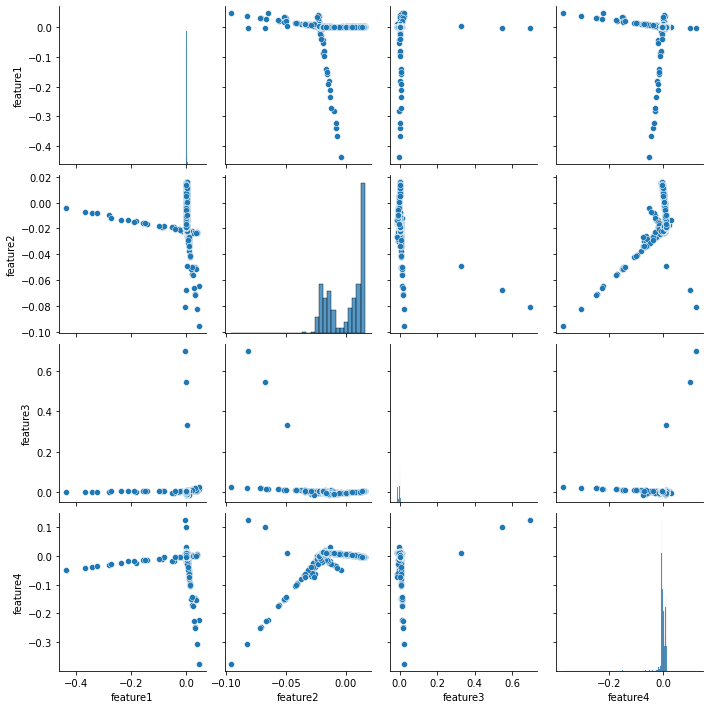

In [202]:
sns.pairplot(df_lle.iloc[:,1:5])

In [203]:
lle_model.reconstruction_error_

4.769560234043337e-07

#### Getting Cosine similarity between all  words

In [204]:
cos_sim_lle = cosine_similarity(df_lle.iloc[:,1:].values, Y=None, dense_output=False)

In [205]:
cos_sim_lle.shape

(4402, 4402)

In [206]:
cos_sim_lle = pd.DataFrame(cos_sim_lle, columns = list(df_lle["Word"]), index = list(df_lle["Word"]))
cos_sim_lle

choice    author       aim     range      view  expertise  \
choice    1.000000 -0.396325 -0.844647 -0.919024 -0.207470  -0.695723   
author   -0.396325  1.000000 -0.104308  0.654499  0.978239  -0.197915   
aim      -0.844647 -0.104308  1.000000  0.680921 -0.307251   0.792401   
range    -0.919024  0.654499  0.680921  1.000000  0.483422   0.417557   
view     -0.207470  0.978239 -0.307251  0.483422  1.000000  -0.340862   
...            ...       ...       ...       ...       ...        ...   
barren    0.974813 -0.202929 -0.921035 -0.830926 -0.008142  -0.825979   
fog       0.962774 -0.179500 -0.940388 -0.831425  0.019163  -0.827305   
sweden    0.994845 -0.311128 -0.878064 -0.878771 -0.120095  -0.761316   
rotation  0.925709 -0.664262 -0.659491 -0.990009 -0.497249  -0.387297   
vanish    0.949123 -0.127542 -0.947340 -0.796575  0.069636  -0.856705   

          geographical  representation    ensure   experts  ...  reactions  \
choice        0.879255        0.912968 -0.816596 -0.857163  ...   0.999366   
author       -0.737199       -0.680648 -0.130859 -0.106749  ...  -0.379386   
aim          -0.556360       -0.582936  0.997856  0.974559  ...  -0.845458   
range        -0.965617       -0.934989  0.663180  0.645464  ...  -0.905516   
view         -0.588186       -0.531516 -0.333275 -0.299430  ...  -0.191634   
...                ...             ...       ...       ...  ...        ...   
barren        0.752613        0.800679 -0.896755 -0.948422  ...   0.977780   
fog           0.732943        0.769450 -0.921178 -0.958559  ...   0.963671   
sweden        0.826652        0.871314 -0.850072 -0.901058  ...   0.996653   
rotation      0.989457        0.972490 -0.636795 -0.624595  ...   0.914790   
vanish        0.694066        0.738048 -0.927873 -0.972504  ...   0.951723   

          pathways   methods   sectors   utterly    barren       fog  \
choice    0.959350 -0.864818  0.964810  0.988330  0.974813  0.962774   
author   -0.146310 -0.079028 -0.165734 -0.517133 -0.202929 -0.179500   
aim      -0.931411  0.943691 -0.929946 -0.774297 -0.921035 -0.940388   
range    -0.795684  0.635487 -0.809680 -0.958669 -0.830926 -0.831425   
view      0.047627 -0.264222  0.029024 -0.336122 -0.008142  0.019163   
...            ...       ...       ...       ...       ...       ...   
barren    0.998042 -0.954403  0.999152  0.929974  1.000000  0.995913   
fog       0.994934 -0.956932  0.996428  0.915093  0.995913  1.000000   
sweden    0.982327 -0.910491  0.985553  0.967868  0.991565  0.980673   
rotation  0.788021 -0.619807  0.801605  0.970947  0.824947  0.814250   
vanish    0.997048 -0.972734  0.997119  0.893017  0.994328  0.998167   

            sweden  rotation    vanish  
choice    0.994845  0.925709  0.949123  
author   -0.311128 -0.664262 -0.127542  
aim      -0.878064 -0.659491 -0.947340  
range    -0.878771 -0.990009 -0.796575  
view     -0.120095 -0.497249  0.069636  
...            ...       ...       ...  
barren    0.991565  0.824947  0.994328  
fog       0.980673  0.814250  0.998167  
sweden    1.000000  0.882937  0.972956  
rotation  0.882937  1.000000  0.779376  
vanish    0.972956  0.779376  1.000000  

[4402 rows x 4402 columns]

In [208]:
words_list = [['man', 'bear'],['heat', 'warm'],['climate', 'weather'],['earth', 'global'], ['scientist', 'publish']]
for word in words_list:
    print("The Cos similarity of LLE embeddings between", word[0], "and", word[1], "is", cos_sim_lle.at[word[0], word[1]])
    similarity(words = word, 
               stem_model = model_stem_claim, 
               lem_model = model_lem_claim
              )

The Cos similarity of LLE embeddings between man and bear is 0.9347039419064723
Stemmed W2V model similarity between man and bear = 0.9782721
Lemmatized W2V model similarity between man and bear = 0.95142007
The Cos similarity of LLE embeddings between heat and warm is 0.974938402053017
Stemmed W2V model similarity between heat and warm = 0.998137
Lemmatized W2V model similarity between heat and warm = 0.9966886
The Cos similarity of LLE embeddings between climate and weather is 0.22364782132996996
Stemmed W2V model similarity between climate and weather = 0.9969926
Lemmatized W2V model similarity between climate and weather = 0.9939381
The Cos similarity of LLE embeddings between earth and global is 0.9875628112415731
Stemmed W2V model similarity between earth and global = 0.99723446
Lemmatized W2V model similarity between earth and global = 0.9940059
The Cos similarity of LLE embeddings between scientist and publish is 0.01930824667859611
Stemmed W2V model similarity between scientis

## TSNE

### Using Stemming

In [209]:
from sklearn.manifold import TSNE

In [210]:
tsne_model = TSNE(n_components=2, init='pca', random_state=0)
tsne_vectors = tsne_model.fit_transform(test_embedding_stem.iloc[:,1:].values)

In [211]:
df_tsne = pd.DataFrame(tsne_vectors, columns = ["feature1", "feature2"])
df_tsne["Word"] = test_embedding_stem["Word"]
df_tsne = df_tsne[["Word", "feature1", "feature2"]]

In [212]:
df_tsne.head()

Word   feature1   feature2
0   choic -15.046539  17.025040
1  author  68.293129 -16.143496
2     aim  35.950386   6.060204
3    rang  63.120163 -32.533188
4    view  46.213783  -8.203163

The positive feature values here are greater that +1 and the negative feature values are less than -1. Why is this different from LLE and PCA and Word2Vec embeddings?

In [213]:
fig = px.scatter(df_tsne, x="feature1", y="feature2",
                 hover_name="Word")
fig.show()

In [112]:
tsne_model.kl_divergence_

1.0583339929580688

In [113]:
tsne_model.n_iter_

999

### Using Lemmatization

In [114]:
tsne_model = TSNE(n_components=2, init='pca', random_state=0)
tsne_vectors = tsne_model.fit_transform(test_embedding_lem.iloc[:,1:].values)

In [115]:
df_tsne_lem = pd.DataFrame(tsne_vectors, columns = ["feature1", "feature2"])
df_tsne_lem["Word"] = test_embedding_lem["Word"]
df_tsne_lem = df_tsne_lem[["Word", "feature1", "feature2"]]

In [116]:
fig = px.scatter(df_tsne_lem, x="feature1", y="feature2",
                 hover_name="Word")
fig.show()

In [117]:
tsne_model.kl_divergence_

1.101688027381897

In [118]:
tsne_model.n_iter_

999

#### Getting Cosine similarity between all  words

In [119]:
cos_sim_tsne = cosine_similarity(df_tsne_lem.iloc[:,1:].values, Y=None, dense_output=False)

In [120]:
cos_sim_tsne.shape

(4402, 4402)

In [121]:
cos_sim_tsne = pd.DataFrame(cos_sim_tsne, columns = list(df_tsne_lem["Word"]), index = list(df_tsne_lem["Word"]))
cos_sim_tsne

choice    author       aim     range      view  expertise  \
choice    1.000000 -0.134477 -0.664879  0.087079 -0.125283  -0.977772   
author   -0.134477  1.000000  0.829577  0.975442  0.999957  -0.076279   
aim      -0.664879  0.829577  1.000000  0.686217  0.824364   0.493486   
range     0.087079  0.975442  0.686217  1.000000  0.977443  -0.294018   
view     -0.125283  0.999957  0.824364  0.977443  1.000000  -0.085521   
...            ...       ...       ...       ...       ...        ...   
barren    0.349277 -0.975478 -0.932135 -0.903045 -0.973395  -0.145047   
fog       0.851487 -0.634119 -0.957819 -0.448238 -0.626922  -0.722613   
sweden    0.931124 -0.486605 -0.891500 -0.282236 -0.478484  -0.833959   
rotation  0.850407  0.406986 -0.172428  0.598179  0.415438  -0.941818   
vanish    0.291472 -0.987087 -0.908311 -0.927565 -0.985559  -0.084425   

          geographical  representation    ensure   experts  ...  reactions  \
choice        0.760321        0.941539 -0.595348 -0.759968  ...   0.981793   
author        0.541402        0.207227  0.876230  0.746256  ...  -0.320256   
aim          -0.020341       -0.374360  0.995986  0.990776  ...  -0.794659   
range         0.713288        0.417612  0.748573  0.581315  ...  -0.103738   
view          0.549175        0.216290  0.871724  0.740051  ...  -0.311458   
...                ...             ...       ...       ...  ...        ...   
barren       -0.343076        0.013174 -0.960807 -0.874466  ...   0.520907   
fog           0.306795        0.625044 -0.928251 -0.987926  ...   0.935590   
sweden        0.471061        0.753820 -0.847370 -0.944667  ...   0.983447   
rotation      0.988326        0.977945 -0.083564 -0.304321  ...   0.734985   
vanish       -0.399732       -0.047842 -0.942108 -0.843248  ...   0.467870   

          pathways   methods   sectors   utterly    barren       fog  \
choice    0.310886 -0.804355  0.063771  0.972008  0.349277  0.851487   
author   -0.983621  0.696920 -0.997475  0.102102 -0.975478 -0.634119   
aim      -0.916639  0.978599 -0.787831 -0.470772 -0.932135 -0.957819   
range    -0.919765  0.521850 -0.988621  0.318698 -0.903045 -0.448238   
view     -0.981907  0.690240 -0.998091  0.111322 -0.973395 -0.626922   
...            ...       ...       ...       ...       ...       ...   
barren    0.999173 -0.837672  0.957386  0.119348  1.000000  0.788756   
fog       0.763108 -0.996455  0.577610  0.704449  0.788756  1.000000   
sweden    0.636105 -0.965642  0.423340  0.819373  0.666954  0.984081   
rotation -0.235674 -0.371432 -0.470823  0.950215 -0.195961  0.448223   
vanish    0.999793 -0.802798  0.973220  0.058565  0.998138  0.749792   

            sweden  rotation    vanish  
choice    0.931124  0.850407  0.291472  
author   -0.486605  0.406986 -0.987087  
aim      -0.891500 -0.172428 -0.908311  
range    -0.282236  0.598179 -0.927565  
view     -0.478484  0.415438 -0.985559  
...            ...       ...       ...  
barren    0.666954 -0.195961  0.998138  
fog       0.984081  0.448223  0.749792  
sweden    1.000000  0.599955  0.620264  
rotation  0.599955  1.000000 -0.255411  
vanish    0.620264 -0.255411  1.000000  

[4402 rows x 4402 columns]

tSNE should have the longest running times.
How can we show the effect of exaggeration factor?